## Blood Pressure Prediction with XGBoost

This script fits an XGBoost model to the biomarkers and systolic blood pressure values found in the previous script `PPG_to_BP_preprocessing`. It illustrates the difference between allowing pulses from the same subject to be a part of both the training and test sets in cross-validation ("leakage"), versus splitting based on subject ID.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_predict, GroupKFold
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV

In [19]:
df_bio = pd.read_csv('biomarkers_PPGBP.csv')

In [ ]:
#scaled X and y
X = df_bio.iloc[:,:-3].to_numpy()
systolic_bp = df_bio['sbp'].to_numpy()
diastolic_bp = df_bio['dbp'].to_numpy()

#IDs are important for grouping in cross-validation
id_array = df_bio['id'].to_numpy()
id_subject = [a.split('_')[0] for a in id_array]


X_scaler = StandardScaler() 
Y_systolic_scaler = StandardScaler()  
Y_diastolic_scaler = StandardScaler()  

X_scaler.fit(X)  
Y_systolic_scaler.fit(systolic_bp.reshape(-1,1)) 
Y_diastolic_scaler.fit(diastolic_bp.reshape(-1,1))

X_scaled = X_scaler.transform(X)  
y_systolic_scaled = Y_systolic_scaler.transform(systolic_bp.reshape(-1,1))  
y_diastolic_scaled = Y_diastolic_scaler.transform(diastolic_bp.reshape(-1,1))

df_bio_scaled = pd.DataFrame(X_scaled)

In [74]:
#create folds

#folds allowing leakage between train and test bc same subject can be in both
cv = KFold(n_splits=3, shuffle=True, random_state=42)

#folds avoiding leakage between train and test bc same subject cannot be in both
cv_no_leak = GroupKFold(n_splits=3, shuffle=True, random_state=42)

## XGBoost model with data leak

In [77]:

regr_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=1,
                        reg_lambda=1,
                        random_state=42,
                        n_jobs=-1)  

distributions = dict(n_estimators=randint(5,2000),
                     max_depth=randint(1,10),
                     learning_rate = loguniform(.001,.2),
                     min_child_weight = loguniform(.1,100),
                     )

reg = RandomizedSearchCV(regr_xgb, distributions,cv=cv, random_state=4,n_iter=20)
search = reg.fit(X_scaled, y_systolic_scaled)
search.best_params_

{'learning_rate': 0.028606655724374586,
 'max_depth': 7,
 'min_child_weight': 5.212780929227981,
 'n_estimators': 1593}

In [78]:
reg_xgb_best_leak = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators = search.best_params_['n_estimators'],
                        learning_rate=search.best_params_['learning_rate'],
                        max_depth=search.best_params_['max_depth'],
                        min_child_weight=search.best_params_['min_child_weight'],
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=1,
                        reg_lambda=1,
                        random_state=42,
                        n_jobs=-1)  

predictions_leak = cross_val_predict(reg_xgb_best_leak, X_scaled, y_systolic_scaled, cv=cv)
xgb_stats_leak = mean_absolute_error(y_systolic_scaled,predictions_leak)*systolic_bp.std(),r2_score(y_systolic_scaled,predictions_leak)
xgb_stats_leak

(11.872164084472358, 0.42460998322723165)

In [79]:
result_df = pd.DataFrame((id_subject,systolic_bp.mean()+predictions_leak*systolic_bp.std(),systolic_bp)).T
result_df.rename(columns = {0:'ID',1:'prediction',2:'true'},inplace=True)
result_df_agg = result_df.groupby('ID').median()

stats_xgb_agg = mean_absolute_error(result_df_agg['prediction'],result_df_agg['true']),r2_score(result_df_agg['true'],result_df_agg['prediction'])


## XGBoost model with*out* data leak

In [80]:
#Now use RandomizedSearchCV with cv_no_leak to avoid leakage between train and test sets

regr_xgb_no_leak = xgb.XGBRegressor(objective='reg:squarederror',
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=1,
                        reg_lambda=1,
                        random_state=42,
                        n_jobs=-1)  

distributions = dict(n_estimators=randint(5,2000),
                     max_depth=randint(1,10),
                     learning_rate = loguniform(.001,.2),
                     min_child_weight = loguniform(.1,100),
                     )

reg_no_leak = RandomizedSearchCV(regr_xgb_no_leak, distributions,cv=cv_no_leak, random_state=4,n_iter=20)
search_no_leak = reg.fit(X_scaled, y_systolic_scaled, groups=id_subject)
search_no_leak.best_params_

/opt/anaconda3/envs/nlp_hw3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


{'learning_rate': 0.028606655724374586,
 'max_depth': 7,
 'min_child_weight': 5.212780929227981,
 'n_estimators': 1593}

In [81]:
reg_xgb_best_no_leak = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators = search_no_leak.best_params_['n_estimators'],
                        learning_rate=search_no_leak.best_params_['learning_rate'],
                        max_depth=search_no_leak.best_params_['max_depth'],
                        min_child_weight=search_no_leak.best_params_['min_child_weight'],
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=1,
                        reg_lambda=1,
                        random_state=42,
                        n_jobs=-1)  

predictions_no_leak = cross_val_predict(reg_xgb_best_no_leak, X_scaled, y_systolic_scaled, cv=cv_no_leak, groups=id_subject)
xgb_stats_no_leak = mean_absolute_error(y_systolic_scaled,predictions_no_leak)*systolic_bp.std(),r2_score(y_systolic_scaled,predictions_no_leak)
xgb_stats_no_leak

(14.100986966395864, 0.2121285115227709)

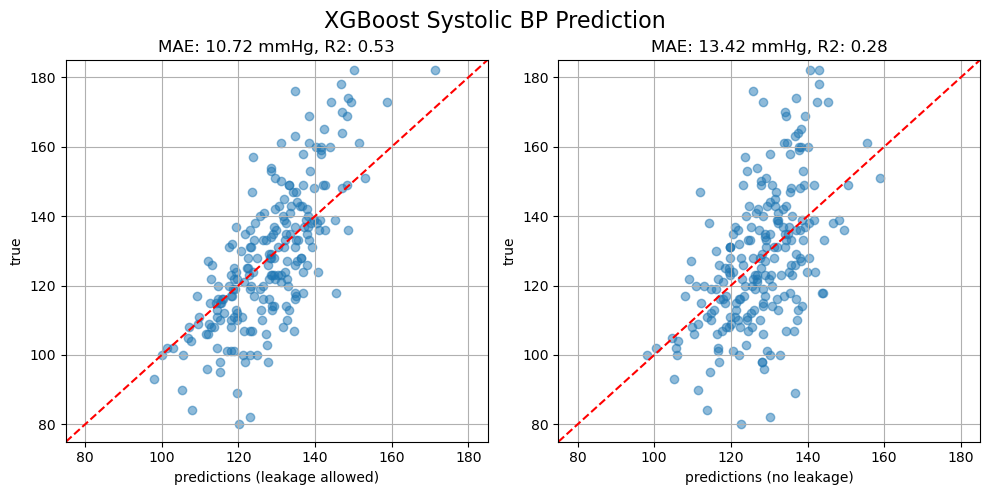

In [82]:

result_df['prediction_no_leak'] = systolic_bp.mean()+predictions_no_leak*systolic_bp.std()

result_df_agg = result_df.groupby('ID').median()

stats_xgb_leak_agg = mean_absolute_error(result_df_agg['prediction'],result_df_agg['true']),r2_score(result_df_agg['true'],result_df_agg['prediction'])
stats_xgb_no_leak_agg = mean_absolute_error(result_df_agg['prediction_no_leak'],result_df_agg['true']),r2_score(result_df_agg['true'],result_df_agg['prediction_no_leak'])

#plot 2x1 figure with predictions with leak on left and no leak on right
prediction_leak_fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(result_df_agg['prediction'],result_df_agg['true'],alpha=0.5)
#plot a 1:1 line for reference
plt.plot([75,185],[75,185],color='red',linestyle='--')
plt.xlabel('predictions (leakage allowed)')
plt.ylabel('true')
plt.xlim([75,185])
plt.ylim([75,185])
plt.title('MAE: {:.2f} mmHg, R2: {:.2f}'.format(stats_xgb_leak_agg[0],stats_xgb_leak_agg[1]))
plt.grid()
plt.subplot(1,2,2)
plt.scatter(result_df_agg['prediction_no_leak'],result_df_agg['true'],alpha=0.5)
#plot a 1:1 line for reference
plt.plot([75,185],[75,185],color='red',linestyle='--')
plt.xlabel('predictions (no leakage)')
plt.ylabel('true')
plt.xlim([75,185])
plt.ylim([75,185])
plt.title('MAE: {:.2f} mmHg, R2: {:.2f}'.format(stats_xgb_no_leak_agg[0],stats_xgb_no_leak_agg[1]))
plt.grid()
plt.tight_layout()
#overall title
prediction_leak_fig.suptitle('XGBoost Systolic BP Prediction', fontsize=16)
prediction_leak_fig.subplots_adjust(top=0.88)
# plt.show()
plt.savefig('XGBoost_SBP_Predictions_Leak_vs_NoLeak.png',dpi=300)
